# Problem

Implement a **DNN** based **regression** model, using **tensorflow**, on a **dataset of your choice**.

# Dataset

We will be using the [Year Prediction Million Song Dataset][1] from the UCI Machine Learning Repository:

> **Abstract:** 
  * Prediction of the release year of a song from audio features. 
  * Songs are mostly western, commercial tracks ranging from 1922 to 2011, with a peak in the year 2000s.
  
  |                           |   
  | ------------------------- |:------------- 
  | Data Set Characteristics: | Multivariate 
  | Number of Instances:      | 515345   
  | Attribute Characteritics: | Real     
  | Number of Attributes:     | 90
  | Date Donated:             | 2011-02-07
  | Associated Tasks:         | Regression
  | Missing Values:           | N/A
  | Number of Web Hits:       | 103568

> **Source:** 
  * This data is a subset of the [Million Song Dataset][2], a collaboration between LabROSA 
  (Columbia University) and The Echo Nest. 
  * Prepared by T. Bertin-Mahieux <tb2332 '@' columbia.edu>

> **Data Set Information:** 
  * You should respect the following train / test split: 
    * `train`: first 463,715 examples 
    * `test`: last 51,630 examples 
  * It avoids the 'producer effect' by making sure no song from a given artist ends up in both 
  the train and test set.

> **Attribute Information:** 
  * 90 attributes, 12 = timbre average, 78 = timbre covariance 
  * The first value is the year (target), ranging from 1922 to 2011. 
  * Features extracted from the 'timbre' features from The Echo Nest API. 
  * We take the average and covariance over all 'segments', each segment being described by a 
  12-dimensional timbre vector.



[1]: https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd#
[2]: http://labrosa.ee.columbia.edu/millionsong/ 

# Prepare the Data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np

In [87]:
# Load the raw data.
num_attributes = 90
names = ['Year'] + ['Attr_{}'.format(i) for i in xrange(num_attributes)]
df = pd.read_csv('YearPredictionMSD.txt', header=None, names=names)

# Validate the data.
num_examples = 515345
assert len(df.columns) == num_attributes + 1
assert len(df) == num_examples
assert not df.isnull().values.any()


# Train/test split. See "Data Set Information".
num_train = 463715
df = df.as_matrix()
train = df[:num_train]
test = df[num_train:]
del df


# Train/val split.
train, val = train_test_split(train, test_size=0.2, shuffle=True)
print 'Train/val/test split: {:.0f}/{:.0f}/{:.0f}'.format(len(train) / float(num_examples) * 100, 
                                              len(val) / float(num_examples) * 100, 
                                              len(test) / float(num_examples) * 100)

# Seperate inputs and outputs.
X_train, y_train = train[:, 1:], train[:, 0]
X_val, y_val = val[:, 1:], val[:, 0]
X_test, y_test = test[:, 1:], test[:, 0]
del train
del val
del test

# Scale data i.e. mean 0 and std 1.
X_train, X_val, X_test = map(preprocessing.scale, [X_train, X_val, X_test])

Train/val/test split: 72/18/10


# Model Tuning/Training

## Baseline

Work done by [Tan et al.][1] shows a best **MAE** of **~6.97** using a **Random Forest**; let's use this value as a **benchmark**.

[1]: https://cseweb.ucsd.edu/classes/wi17/cse258-a/reports/a028.pdf

In [138]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()  # Applies seaborn style defaults to matplotlib

from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras.optimizers import Adam

import random

## Random Search

### Single Hidden Layer

Let's constrain our search, initially, to 1 hidden layer.

In [150]:
num_experiments = 5

for i in xrange(num_experiments):
    units = random.choice([2048])
#     lr = 10**np.random.uniform(-7, 0)
    lr = 0.1
    
    model = Sequential()
    model.add(Dense(input_dim=num_attributes, units=units, activation='relu'))
    model.add(Dense(units=1))

    optimizer = Adam(lr=lr)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=4, verbose=True)
    
    print units, lr, history.history['val_mean_absolute_error'][-1]

Train on 370972 samples, validate on 92743 samples
Epoch 1/4
370972/370972 [==============================]370972/370972 [==============================] - 43s 117us/step - loss: 112649.5135 - mean_absolute_error: 135.5901 - val_loss: 203.5794 - val_mean_absolute_error: 9.3962

Epoch 2/4
126656/370972 [=========>....................]126656/370972 [=========>....................] - ETA: 27s - loss: 367.2732 - mean_absolute_error: 12.1179

KeyboardInterrupt: 

In [ ]:
def plot(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


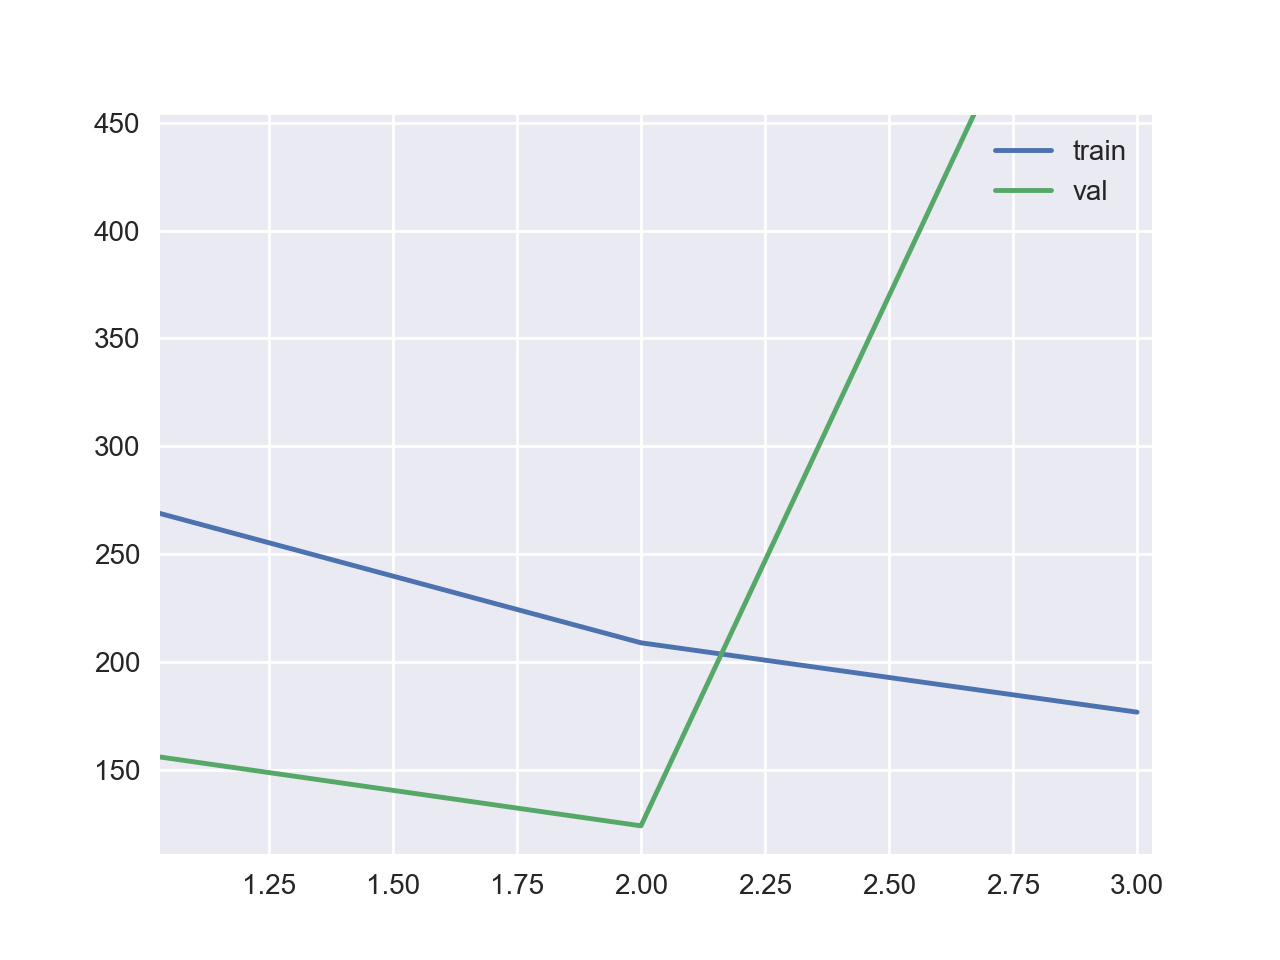

In [147]:
plot(history)

In [131]:
model.evaluate(X_test, y_test)

51630/51630 [==============================]51630/51630 [==============================] - 1s 26us/step



[109.65447297954245, 7.794964002579329]

In [89]:
y_val.shape

(92743,)

In [92]:
X_train.shape

(370972, 90)

In [93]:
y_train.shape

(370972,)